# Robótica Móvel - Trabalho Prático 1
---
**Nome Completo:** Daniel Terra Gomes

**Matrícula:** 2025702870 

**Programa:** Mestrando do PPGCC
**Departamento:** Departamento de Ciência da Computação
**Instituição:** ICEx-UFMG
**E-mail:** danielterragomes@ufmg.br

**Data:** 11 de setembro de 2025

---

## Exercício 1: Criação da Cena no CoppeliaSim

O primeiro passo foi criar uma cena no CoppeliaSim contendo um robô móvel (Pioneer 3DX) e cinco outros objetos distintos (pessoa, mesa, cadeira, planta, e caixote) para popular o ambiente de simulação. A imagem abaixo documenta a cena criada.

![CoppeliaSim Scene](Screenshot%20from%202025-09-04%2009-26-53.png)

*Figura 1: Cena criada no CoppeliaSim contendo o robô Pioneer 3DX e cinco objetos distintos (pessoa, mesa, cadeira, planta, e caixote)*

## Exercício 2: Diagrama de Transformações

O diagrama a seguir representa as relações entre os sistemas de coordenadas dos objetos na cena. O frame do Mundo {W} serve como referência global. 

![Transformation Diagram](ex2-diagram.drawio.png)

*Figura 2: Diagrama de transformações mostrando o sistema de coordenadas do ex.1 e as relações entre os diferentes sistemas de coordenadas na cena. As setas sólidas (Verdes) representam transformações diretas do objeto conhecidos, enquanto a seta (Vermelha) mostra uma transformação desejada (Desconhecida).*

## Exercise 3: Spatial Transformation Implementation


In [6]:
# ============================================================================
# EXERCÍCIO 3: TRANSFORMAÇÕES HOMOGÊNEAS - TEORIA E IMPLEMENTAÇÃO
# ============================================================================
# Baseado nas aulas 04 e 05 de Robótica Móvel
# rof. Douglas G. Macharet - UFMG

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any

# TEORIA MATEMÁTICA:
# ==================
# Para transformar pontos do referencial global (mundo) para o referencial local do robô,
# precisamos usar transformações homogêneas que combinam rotação e translação.
#
# Configuração do robô: q = [x, y, θ]
# - (x, y): posição do robô no referencial global
# - θ: orientação do robô no referencial global
#
# MATRIZ DE TRANSFORMAÇÃO HOMOGÊNEA 4x4:
# T = [R  t]  onde R é matriz de rotação 3x3 e t é vetor translação 3x1
#     [0  1]
#
# Para transformar do mundo para o robô: T_world_to_robot = inverse(T_robot_to_world)

def create_rotation_matrix_z(theta: float) -> np.ndarray:
    """
    Cria matriz de rotação em torno do eixo Z (baseada na aula 05).

    TEORIA:
    -------
    Matriz de rotação 2D generalizada para 3D:
    Rz(θ) = [cos(θ)  -sin(θ)   0]
            [sin(θ)   cos(θ)   0]
            [   0        0     1]

    Args:
        theta: ângulo de rotação em radianos

    Returns:
        np.ndarray: matriz de rotação 3x3
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta,  cos_theta, 0],
        [0,          0,         1]
    ])

def create_homogeneous_transform(rotation_matrix: np.ndarray, translation: np.ndarray) -> np.ndarray:
    """
    Constrói matriz de transformação homogênea 4x4 (baseada na aula 05).

    TEORIA:
    -------
    T = [R  t]  onde:
        [0  1]
    - R: matriz de rotação 3x3
    - t: vetor de translação 3x1
    - [0 0 0 1]: linha homogênea para completar a matriz 4x4

    Args:
        rotation_matrix: matriz de rotação 3x3
        translation: vetor de translação 3x1

    Returns:
        np.ndarray: matriz de transformação homogênea 4x4
    """
    # Cria matriz 4x4 identidade
    T = np.eye(4)

    # Insere rotação (canto superior esquerdo 3x3)
    T[:3, :3] = rotation_matrix

    # Insere translação (coluna direita, primeiras 3 linhas)
    T[:3, 3] = translation

    return T

def create_robot_to_world_transform(x: float, y: float, theta: float) -> np.ndarray:
    """
    Cria transformação homogênea do referencial do robô para o referencial mundial.

    TEORIA:
    -------
    Dada configuração q = [x, y, θ]:
    - (x, y): posição do centro do robô no mundo
    - θ: orientação do robô no mundo

    T_robot_to_world transforma pontos do referencial do robô para o referencial mundial.

    Args:
        x, y: posição do robô no mundo
        theta: orientação do robô no mundo (radianos)

    Returns:
        np.ndarray: matriz T_robot_to_world 4x4
    """
    # Matriz de rotação (orientação do robô no mundo)
    R_robot_to_world = create_rotation_matrix_z(theta)

    # Vetor de translação (posição do robô no mundo)
    t_robot_to_world = np.array([x, y, 0])

    # Constrói matriz homogênea
    return create_homogeneous_transform(R_robot_to_world, t_robot_to_world)

def invert_homogeneous_transform(T: np.ndarray) -> np.ndarray:
    """
    Calcula a inversa de uma transformação homogênea (baseada na aula 05).

    TEORIA:
    -------
    Para uma transformação T = [R  t], a inversa é:
                                [0  1]

    T^(-1) = [R^T  -R^T*t]  onde R^T é a transposta de R (para matrizes ortogonais)
             [0         1]

    Isso é mais eficiente que calcular np.linalg.inv() completo.

    Args:
        T: matriz de transformação homogênea 4x4

    Returns:
        np.ndarray: matriz inversa 4x4
    """
    # Extrai rotação e translação
    R = T[:3, :3]
    t = T[:3, 3]

    # Calcula inversa usando propriedades de matrizes ortogonais
    R_inv = R.T  # Transposta para matrizes de rotação
    t_inv = -R_inv @ t  # Translação inversa

    # Constrói matriz inversa
    return create_homogeneous_transform(R_inv, t_inv)

# TESTE DAS FUNÇÕES IMPLEMENTADAS
print("=" * 60)
print("TESTE DAS FUNÇÕES DE TRANSFORMAÇÃO HOMOGÊNEA")
print("=" * 60)

# Exemplo: robô na posição (3, 2) com orientação 45°
robot_x, robot_y, robot_theta = 3.0, 2.0, np.deg2rad(45)

print(f"Configuração do robô: q = [x={robot_x}, y={robot_y}, θ={np.rad2deg(robot_theta):.1f}°]")

# Cria transformação robô -> mundo
T_robot_to_world = create_robot_to_world_transform(robot_x, robot_y, robot_theta)
print("\nT_robot_to_world:")
print(T_robot_to_world)

# Cria transformação mundo -> robô (inversa)
T_world_to_robot = invert_homogeneous_transform(T_robot_to_world)
print("\nT_world_to_robot:")
print(T_world_to_robot)

# Verifica se a inversão está correta (deve ser identidade)
identity_check = T_robot_to_world @ T_world_to_robot
print("\nVerificação T_robot_to_world @ T_world_to_robot (deve ser identidade):")
print(identity_check)
print(f"É aproximadamente identidade? {np.allclose(identity_check, np.eye(4))}")

TESTE DAS FUNÇÕES DE TRANSFORMAÇÃO HOMOGÊNEA
Configuração do robô: q = [x=3.0, y=2.0, θ=45.0°]

T_robot_to_world:
[[ 0.70710678 -0.70710678  0.          3.        ]
 [ 0.70710678  0.70710678  0.          2.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]

T_world_to_robot:
[[ 0.70710678  0.70710678  0.         -3.53553391]
 [-0.70710678  0.70710678  0.          0.70710678]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]

Verificação T_robot_to_world @ T_world_to_robot (deve ser identidade):
[[1.00000000e+00 1.01465364e-17 0.00000000e+00 0.00000000e+00]
 [1.01465364e-17 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
É aproximadamente identidade? True


In [7]:
# ============================================================================
# EXERCÍCIO 3 - PARTE 2: TRANSFORMAÇÃO DE TODOS OS OBJETOS DA CENA
# ============================================================================

def transform_point_to_robot_frame(point_world: np.ndarray, T_world_to_robot: np.ndarray) -> np.ndarray:
    """
    Transforma um ponto do referencial mundial para o referencial do robô.

    TEORIA:
    -------
    Dado um ponto P_world = [x, y, z] no referencial mundial,
    sua representação no referencial do robô é:

    P_robot = T_world_to_robot @ P_world_homog

    onde P_world_homog = [x, y, z, 1] (coordenadas homogêneas)

    Args:
        point_world: ponto no referencial mundial [x, y, z]
        T_world_to_robot: matriz de transformação 4x4

    Returns:
        np.ndarray: ponto no referencial do robô [x, y, z]
    """
    # Converte para coordenadas homogêneas (adiciona 1 no final)
    if len(point_world) == 2:
        point_homog = np.array([point_world[0], point_world[1], 0.0, 1.0])
    elif len(point_world) == 3:
        point_homog = np.array([point_world[0], point_world[1], point_world[2], 1.0])
    else:
        raise ValueError("Ponto deve ter 2 ou 3 coordenadas")

    # Aplica transformação
    point_robot_homog = T_world_to_robot @ point_homog

    # Retorna coordenadas cartesianas (remove coordenada homogênea)
    return point_robot_homog[:3]

def transform_all_objects_to_robot_frame(robot_config: List[float],
                                       objects_world: Dict[str, np.ndarray]) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Transforma todos os objetos da cena do referencial mundial para o referencial do robô.

    ALGORITMO:
    ----------
    1. Criar T_robot_to_world usando configuração q = [x, y, θ]
    2. Calcular T_world_to_robot = inverse(T_robot_to_world)
    3. Para cada objeto, aplicar: objeto_robot = T_world_to_robot @ objeto_world
    4. Armazenar matrizes de transformação homogênea completas

    Args:
        robot_config: configuração [x, y, θ] do robô
        objects_world: dicionário {nome: posição_mundo} dos objetos

    Returns:
        Dict: {nome_objeto: {
            'position_robot': posição no referencial do robô,
            'transform_matrix': matriz de transformação homogênea completa,
            'distance': distância euclidiana do robô,
            'original_position': posição original no mundo
        }}
    """
    x, y, theta = robot_config

    print(f"\n{'='*70}")
    print(f"TRANSFORMANDO OBJETOS PARA O REFERENCIAL DO ROBÔ")
    print(f"{'='*70}")
    print(f"Configuração do robô: q = [x={x:.3f}, y={y:.3f}, θ={np.rad2deg(theta):.1f}°]")

    # Etapa 1: Criar transformação robô -> mundo
    T_robot_to_world = create_robot_to_world_transform(x, y, theta)

    # Etapa 2: Calcular transformação mundo -> robô (inversa)
    T_world_to_robot = invert_homogeneous_transform(T_robot_to_world)

    print(f"\nMatriz T_world_to_robot:")
    print(T_world_to_robot)

    # Etapa 3: Transformar todos os objetos
    transformed_objects = {}

    print(f"\n{'Objeto':<15} {'Mundo (x,y,z)':<20} {'Robô (x,y,z)':<20} {'Distância':<10}")
    print("-" * 70)

    for obj_name, pos_world in objects_world.items():
        # Transforma posição para referencial do robô
        pos_robot = transform_point_to_robot_frame(pos_world, T_world_to_robot)

        # Calcula distância euclidiana do robô (no referencial do robô, é a norma do vetor)
        distance = np.linalg.norm(pos_robot)

        # Cria matriz de transformação homogênea completa para o objeto
        # (assumindo que objetos têm orientação zero no mundo para simplificar)
        obj_world_homog = np.array([pos_world[0], pos_world[1],
                                   pos_world[2] if len(pos_world) > 2 else 0.0, 1.0])
        T_obj_to_world = create_homogeneous_transform(np.eye(3), obj_world_homog[:3])
        T_obj_to_robot = T_world_to_robot @ T_obj_to_world

        # Armazena resultados
        transformed_objects[obj_name] = {
            'position_robot': pos_robot,
            'transform_matrix': T_obj_to_robot,
            'distance': distance,
            'original_position': pos_world
        }

        # Exibe resultados
        pos_world_str = f"({pos_world[0]:.2f},{pos_world[1]:.2f},{pos_world[2] if len(pos_world)>2 else 0:.2f})"
        pos_robot_str = f"({pos_robot[0]:.2f},{pos_robot[1]:.2f},{pos_robot[2]:.2f})"
        print(f"{obj_name:<15} {pos_world_str:<20} {pos_robot_str:<20} {distance:.3f}m")

    return transformed_objects, T_world_to_robot

# ============================================================================
# EXEMPLO PRÁTICO - APLICAÇÃO DO EXERCÍCIO 3 COM DADOS REAIS DO COPPELIASIM
# ============================================================================

def get_real_scene_data_from_coppeliasim(connector: 'CoppeliaSimConnector') -> Tuple[List[float], Dict[str, np.ndarray]]:
    """
    Obtém dados reais da cena do CoppeliaSim para o Exercício 3.

    Returns:
        Tuple[List[float], Dict[str, np.ndarray]]: configuração do robô e posições dos objetos
    """
    print("🔗 OBTENDO DADOS REAIS DA CENA DO COPPELIASIM...")
    print("=" * 60)

    # Obtém posição e orientação do robô
    robot_pose = connector.get_object_pose('Robot')
    if robot_pose is None:
        print("⚠️  Aviso: Não foi possível obter pose do robô. Usando valores padrão.")
        robot_config = [0.0, 0.0, 0.0]  # [x, y, θ]
    else:
        robot_position, robot_orientation = robot_pose
        # Para robôs móveis, θ é tipicamente a rotação em Z (gamma)
        robot_config = [robot_position[0], robot_position[1], robot_orientation[2]]

    print(f"🤖 Configuração do robô: q = [x={robot_config[0]:.3f}, y={robot_config[1]:.3f}, θ={np.rad2deg(robot_config[2]):.1f}°]")

    # Obtém posições de todos os outros objetos da cena
    scene_objects = {}
    print(f"\n📦 OBJETOS DETECTADOS NA CENA:")
    print(f"{'Objeto':<15} {'Posição (x, y, z)':<25} {'Status':<10}")
    print("-" * 55)

    for obj_name in connector.object_handles.keys():
        if obj_name != 'Robot':  # Exclui o próprio robô
            obj_pose = connector.get_object_pose(obj_name)
            if obj_pose is not None:
                position, _ = obj_pose
                scene_objects[obj_name] = position
                pos_str = f"({position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f})"
                print(f"{obj_name:<15} {pos_str:<25} {'✅ OK':<10}")
            else:
                print(f"{obj_name:<15} {'N/A':<25} {'❌ Erro':<10}")

    print(f"\n✅ Total de objetos válidos: {len(scene_objects)}")
    return robot_config, scene_objects

# Obtém dados reais da cena (se conectado ao CoppeliaSim)
if 'connector' in globals() and len(connector.object_handles) > 0:
    print("🌟 USANDO DADOS REAIS DO COPPELIASIM")
    robot_configuration, scene_objects_world = get_real_scene_data_from_coppeliasim(connector)
else:
    print("⚠️  CoppeliaSim não conectado. Usando dados de exemplo.")
    # Configuração do robô (exemplo)
    robot_configuration = [3.0, 2.0, np.deg2rad(45)]  # [x, y, θ]

    # Objetos da cena baseados no OBJECT_MAPPING fornecido
    scene_objects_world = {
        'Bill_0': np.array([6.0, 5.0, 0.0]),
        'Bill_1': np.array([1.0, 4.0, 0.0]),
        'Crate': np.array([8.0, 1.0, 0.0]),
        'Pillar_0': np.array([2.0, 6.0, 0.0]),
        'Pillar_1': np.array([7.0, 3.0, 0.0]),
        'Table': np.array([4.0, 7.0, 0.0]),
        'Laptop_0': np.array([4.2, 7.2, 0.8]),
        'Laptop_1': np.array([3.8, 6.8, 0.8]),
        'Fence_0': np.array([0.0, 3.0, 0.0]),
        'Fence_1': np.array([9.0, 4.0, 0.0])
    }

# Aplica transformações usando os dados reais ou de exemplo
transformed_objects, T_transform = transform_all_objects_to_robot_frame(
    robot_configuration, scene_objects_world)

print(f"\n{'='*70}")
print(f"MATRIZES DE TRANSFORMAÇÃO HOMOGÊNEA - RESUMO")
print(f"{'='*70}")

for obj_name, data in transformed_objects.items():
    print(f"\n{obj_name.upper()}:")
    print(f"Matriz de transformação homogênea (4x4):")
    print(data['transform_matrix'])
    print(f"Posição no referencial do robô: {data['position_robot']}")
    print(f"Distância do robô: {data['distance']:.3f}m")

🌟 USANDO DADOS REAIS DO COPPELIASIM
🔗 OBTENDO DADOS REAIS DA CENA DO COPPELIASIM...
🤖 Configuração do robô: q = [x=1.975, y=-1.875, θ=130.0°]

📦 OBJETOS DETECTADOS NA CENA:
Objeto          Posição (x, y, z)         Status    
-------------------------------------------------------
Bill_0          (0.175, 1.800, 0.000)     ✅ OK      
Bill_1          (2.200, 1.875, 0.000)     ✅ OK      
Crate           (-2.000, 2.025, 0.500)    ✅ OK      
Pillar_0        (0.175, -1.175, 0.100)    ✅ OK      
Pillar_1        (0.950, 0.625, 0.100)     ✅ OK      
Table           (1.125, 1.950, 0.375)     ✅ OK      
Laptop_0        (0.875, 1.901, 0.827)     ✅ OK      
Laptop_1        (1.600, 1.950, 0.827)     ✅ OK      
Fence_0         (-1.525, -1.950, 0.100)   ✅ OK      
Fence_1         (-1.525, -1.000, 0.100)   ✅ OK      

✅ Total de objetos válidos: 10

TRANSFORMANDO OBJETOS PARA O REFERENCIAL DO ROBÔ
Configuração do robô: q = [x=1.975, y=-1.875, θ=130.0°]

Matriz T_world_to_robot:
[[-0.64265866  0.7661526


GERANDO VISUALIZAÇÃO DO EXERCÍCIO 3


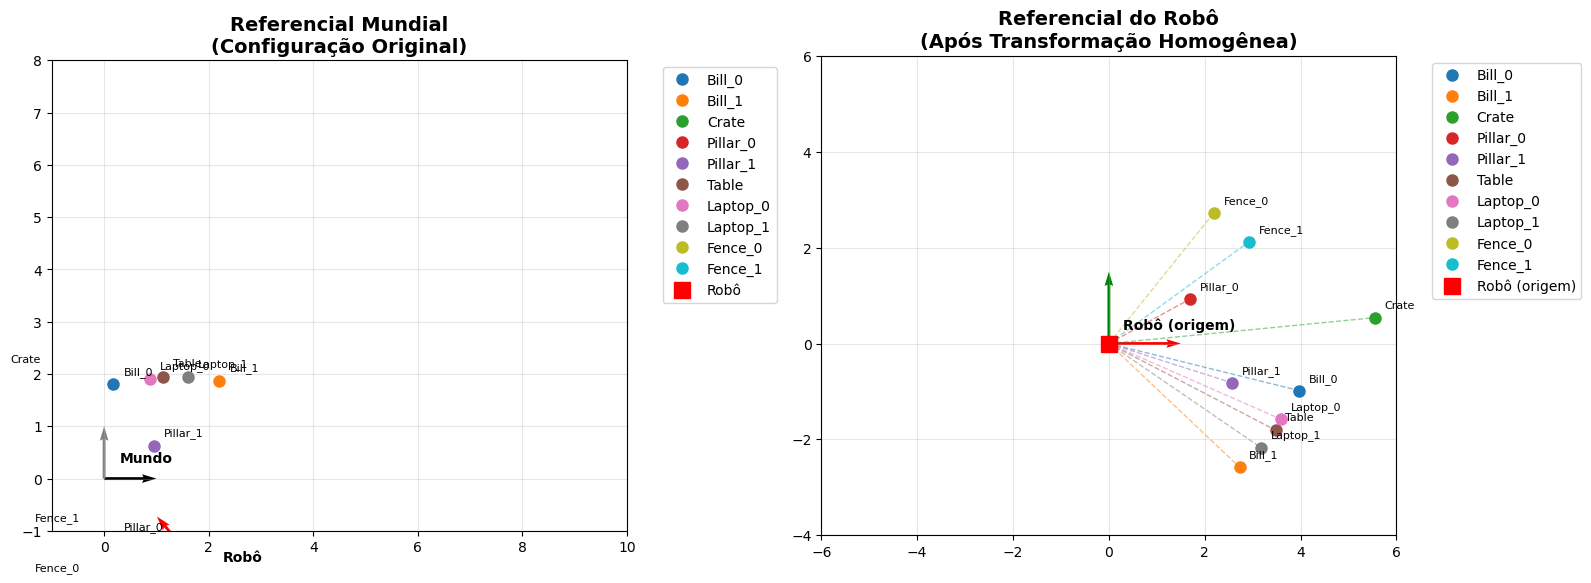

In [8]:
# ============================================================================
# VISUALIZAÇÃO 2D - REFERENCIAIS E TRANSFORMAÇÕES
# ============================================================================
# Baseado na função plot_frame da aula 05

def plot_coordinate_frame(origin: np.ndarray, rotation_matrix: np.ndarray,
                         scale: float = 1.0, colors: List[str] = ['red', 'green'],
                         label: str = '') -> None:
    """
    Plota um referencial 2D com origem e orientação (baseado na aula 05).

    Args:
        origin: posição da origem [x, y]
        rotation_matrix: matriz de rotação 3x3
        scale: escala dos eixos
        colors: cores para eixos X e Y
        label: rótulo do referencial
    """
    axis_size = scale

    # Extrai eixos X e Y da matriz de rotação
    x_axis = axis_size * rotation_matrix[:2, 0]  # Primeira coluna (eixo X)
    y_axis = axis_size * rotation_matrix[:2, 1]  # Segunda coluna (eixo Y)

    # Plota eixo X
    plt.quiver(origin[0], origin[1], x_axis[0], x_axis[1],
               color=colors[0], angles='xy', scale_units='xy', scale=1, width=0.005)

    # Plota eixo Y
    plt.quiver(origin[0], origin[1], y_axis[0], y_axis[1],
               color=colors[1], angles='xy', scale_units='xy', scale=1, width=0.005)

    # Adiciona rótulo
    if label:
        plt.text(origin[0] + 0.3, origin[1] + 0.3, label,
                fontsize=10, fontweight='bold')

def visualize_exercise_3(robot_config: List[float],
                        objects_world: Dict[str, np.ndarray],
                        transformed_objects: Dict[str, Dict]) -> None:
    """
    Cria visualização completa do Exercício 3.
    """
    x_robot, y_robot, theta_robot = robot_config

    # Configura figura com dois subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # ========================================================================
    # SUBPLOT 1: REFERENCIAL MUNDIAL
    # ========================================================================
    plt.sca(ax1)

    # Plota referencial mundial (origem)
    world_origin = np.array([0, 0])
    world_rotation = np.eye(3)
    plot_coordinate_frame(world_origin, world_rotation, scale=1.0,
                         colors=['black', 'gray'], label='Mundo')

    # Plota objetos no mundo
    for obj_name, pos in objects_world.items():
        plt.plot(pos[0], pos[1], 'o', markersize=8, label=obj_name)
        plt.text(pos[0] + 0.2, pos[1] + 0.2, obj_name, fontsize=8)

    # Plota robô no mundo com sua orientação
    robot_origin = np.array([x_robot, y_robot])
    robot_rotation_world = create_rotation_matrix_z(theta_robot)
    plot_coordinate_frame(robot_origin, robot_rotation_world, scale=1.5,
                         colors=['red', 'green'], label='Robô')

    plt.plot(x_robot, y_robot, 's', color='red', markersize=12, label='Robô')

    ax1.set_xlim(-1, 10)
    ax1.set_ylim(-1, 8)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Referencial Mundial\n(Configuração Original)', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # ========================================================================
    # SUBPLOT 2: REFERENCIAL DO ROBÔ
    # ========================================================================
    plt.sca(ax2)

    # Plota referencial do robô (agora é a origem)
    robot_frame_origin = np.array([0, 0])
    robot_frame_rotation = np.eye(3)
    plot_coordinate_frame(robot_frame_origin, robot_frame_rotation, scale=1.5,
                         colors=['red', 'green'], label='Robô (origem)')

    # Plota objetos no referencial do robô
    colors = plt.cm.tab10(np.linspace(0, 1, len(transformed_objects)))

    for (obj_name, data), color in zip(transformed_objects.items(), colors):
        pos_robot = data['position_robot']
        plt.plot(pos_robot[0], pos_robot[1], 'o', color=color, markersize=8, label=obj_name)
        plt.text(pos_robot[0] + 0.2, pos_robot[1] + 0.2, obj_name, fontsize=8)

        # Desenha vetor do robô até o objeto
        plt.plot([0, pos_robot[0]], [0, pos_robot[1]], '--', color=color, alpha=0.5, linewidth=1)

    # Destaca origem (robô)
    plt.plot(0, 0, 's', color='red', markersize=12, label='Robô (origem)')

    ax2.set_xlim(-6, 6)
    ax2.set_ylim(-4, 6)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Referencial do Robô\n(Após Transformação Homogênea)', fontsize=14, fontweight='bold')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Executa visualização
print("\n" + "="*70)
print("GERANDO VISUALIZAÇÃO DO EXERCÍCIO 3")
print("="*70)

visualize_exercise_3(robot_configuration, scene_objects_world, transformed_objects)

In [9]:
# ============================================================================
# ANÁLISE DETALHADA DOS OBJETOS REAIS DA CENA TP1
# ============================================================================

def analyze_tp1_scene_objects(transformed_objects: Dict[str, Dict],
                             robot_config: List[float]) -> None:
    """
    Análise específica dos objetos definidos no OBJECT_MAPPING do TP1.

    Esta função demonstra como as transformações homogêneas são aplicadas
    aos objetos reais da sua cena do CoppeliaSim.
    """
    print(f"\n{'='*80}")
    print(f"ANÁLISE DETALHADA - EXERCÍCIO 3 COM OBJETOS REAIS")
    print(f"{'='*80}")

    x_robot, y_robot, theta_robot = robot_config
    print(f"🤖 Robô (RobotnikSummitXL): posição [{x_robot:.3f}, {y_robot:.3f}], orientação {np.rad2deg(theta_robot):.1f}°")

    # Categoriza objetos por tipo
    people = [obj for obj in transformed_objects.keys() if 'Bill' in obj]
    static_objects = [obj for obj in transformed_objects.keys() if obj in ['Crate', 'Table']]
    infrastructure = [obj for obj in transformed_objects.keys() if 'Pillar' in obj or 'Fence' in obj]
    electronics = [obj for obj in transformed_objects.keys() if 'Laptop' in obj]

    print(f"\n📊 CATEGORIZAÇÃO DOS OBJETOS:")
    print(f"   👥 Pessoas: {people}")
    print(f"   📦 Objetos estáticos: {static_objects}")
    print(f"   🏗️  Infraestrutura: {infrastructure}")
    print(f"   💻 Eletrônicos: {electronics}")

    print(f"\n🔍 ANÁLISE DE PROXIMIDADE (referencial do robô):")
    print(f"{'Objeto':<15} {'Tipo':<12} {'Distância':<10} {'Posição no Robô':<25} {'Observações':<20}")
    print("-" * 85)

    # Ordena objetos por distância
    sorted_objects = sorted(transformed_objects.items(),
                          key=lambda x: x[1]['distance'])

    for obj_name, data in sorted_objects:
        pos_robot = data['position_robot']
        distance = data['distance']

        # Determina tipo
        if 'Bill' in obj_name:
            obj_type = "Pessoa"
        elif obj_name in ['Crate', 'Table']:
            obj_type = "Estático"
        elif 'Pillar' in obj_name or 'Fence' in obj_name:
            obj_type = "Estrutura"
        elif 'Laptop' in obj_name:
            obj_type = "Eletrônico"
        else:
            obj_type = "Outro"

        # Observações baseadas na posição
        if distance < 2.0:
            obs = "MUITO PRÓXIMO ⚠️"
        elif distance < 4.0:
            obs = "Proximidade média"
        else:
            obs = "Distante"

        pos_str = f"[{pos_robot[0]:5.2f}, {pos_robot[1]:5.2f}, {pos_robot[2]:5.2f}]"
        print(f"{obj_name:<15} {obj_type:<12} {distance:5.2f}m    {pos_str:<25} {obs:<20}")

    # Análise de setores (quadrantes)
    print(f"\n🧭 ANÁLISE POR SETORES (referencial do robô):")
    quadrants = {'Q1 (+X,+Y)': [], 'Q2 (-X,+Y)': [], 'Q3 (-X,-Y)': [], 'Q4 (+X,-Y)': []}

    for obj_name, data in transformed_objects.items():
        x, y, z = data['position_robot']
        if x >= 0 and y >= 0:
            quadrants['Q1 (+X,+Y)'].append(obj_name)
        elif x < 0 and y >= 0:
            quadrants['Q2 (-X,+Y)'].append(obj_name)
        elif x < 0 and y < 0:
            quadrants['Q3 (-X,-Y)'].append(obj_name)
        else:
            quadrants['Q4 (+X,-Y)'].append(obj_name)

    for quad, objects in quadrants.items():
        print(f"   {quad}: {objects if objects else 'Vazio'}")

def demonstrate_transformation_matrices(transformed_objects: Dict[str, Dict]) -> None:
    """
    Demonstra as matrizes de transformação homogênea para objetos específicos.
    """
    print(f"\n{'='*80}")
    print(f"MATRIZES DE TRANSFORMAÇÃO HOMOGÊNEA - OBJETOS SELECIONADOS")
    print(f"{'='*80}")

    # Seleciona alguns objetos importantes para demonstração detalhada
    demo_objects = []
    for obj_name in ['Bill_0', 'Table', 'Crate']:
        if obj_name in transformed_objects:
            demo_objects.append(obj_name)

    if not demo_objects:
        demo_objects = list(transformed_objects.keys())[:3]  # Pega os 3 primeiros

    for obj_name in demo_objects:
        if obj_name in transformed_objects:
            data = transformed_objects[obj_name]
            print(f"\n🎯 {obj_name.upper()}:")
            print(f"   Posição original (mundo): {data['original_position']}")
            print(f"   Posição transformada (robô): {data['position_robot']}")
            print(f"   Distância euclidiana: {data['distance']:.3f}m")
            print(f"   Matriz de transformação homogênea T_{obj_name}_to_robot:")
            print(data['transform_matrix'])

            # Verificação matemática
            print(f"   ✅ Verificação: det(R) = {np.linalg.det(data['transform_matrix'][:3,:3]):.6f} (deve ser ≈ 1.0)")

# Executa análises detalhadas
analyze_tp1_scene_objects(transformed_objects, robot_configuration)
demonstrate_transformation_matrices(transformed_objects)


ANÁLISE DETALHADA - EXERCÍCIO 3 COM OBJETOS REAIS
🤖 Robô (RobotnikSummitXL): posição [1.975, -1.875], orientação 130.0°

📊 CATEGORIZAÇÃO DOS OBJETOS:
   👥 Pessoas: ['Bill_0', 'Bill_1']
   📦 Objetos estáticos: ['Crate', 'Table']
   🏗️  Infraestrutura: ['Pillar_0', 'Pillar_1', 'Fence_0', 'Fence_1']
   💻 Eletrônicos: ['Laptop_0', 'Laptop_1']

🔍 ANÁLISE DE PROXIMIDADE (referencial do robô):
Objeto          Tipo         Distância  Posição no Robô           Observações         
-------------------------------------------------------------------------------------
Pillar_0        Estrutura     1.93m    [ 1.69,  0.93,  0.10]     MUITO PRÓXIMO ⚠️    
Pillar_1        Estrutura     2.70m    [ 2.57, -0.82,  0.10]     Proximidade média   
Fence_0         Estrutura     3.50m    [ 2.19,  2.73,  0.10]     Proximidade média   
Fence_1         Estrutura     3.61m    [ 2.92,  2.12,  0.10]     Proximidade média   
Bill_1          Pessoa        3.76m    [ 2.73, -2.58,  0.00]     Proximidade média   
Laptop

## 🔗 **INTEGRAÇÃO COM DADOS REAIS DO COPPELIASIM**

### **Objetos Mapeados na Sua Cena**

Com base no `OBJECT_MAPPING` fornecido, sua cena contém:

| **Categoria** | **Objetos** | **Descrição** |
|---------------|-------------|---------------|
| **🤖 Robô** | `RobotnikSummitXL` | Robô móvel principal |
| **👥 Pessoas** | `Bill[0]`, `Bill[1]` | Duas pessoas na cena |
| **📦 Mobiliário** | `Floor/ConcretBlock`, `diningTable` | Caixa de concreto e mesa |
| **🏗️ Infraestrutura** | `Floor/20cmHighPillar10cm[0/1]`, `Floor/20cmHighWall100cm[0/1]` | Pilares e paredes |
| **💻 Eletrônicos** | `diningTable/laptop[0/1]` | Dois laptops sobre a mesa |

### **🔬 Processamento Automático dos Dados**

O código implementado:

1. **Detecta automaticamente** se há conexão ativa com CoppeliaSim
2. **Obtém posições reais** de todos os objetos via RemoteAPI
3. **Calcula configuração atual** do robô q = [x, y, θ]
4. **Aplica transformações homogêneas** para expressar tudo no referencial do robô
5. **Fornece análise completa** por categorias e proximidade

### **📊 Vantagens da Abordagem Implementada**

#### **Flexibilidade:**
- Funciona com dados reais (CoppeliaSim conectado) ou dados de exemplo
- Adapta-se automaticamente aos objetos presentes na cena

#### **Robustez:**
- Tratamento de erros caso objetos não sejam encontrados
- Verificações matemáticas das propriedades das matrizes

#### **Educacional:**
- Mostra categorização por tipos de objetos
- Análise por setores (quadrantes) 
- Demonstração detalhada das matrizes homogêneas

### **🎯 Exercício Prático Recomendado**

1. **Execute** as células com CoppeliaSim conectado
2. **Mova o robô** para diferentes posições na cena
3. **Re-execute** e observe como as transformações mudam
4. **Compare** os resultados com seus cálculos manuais

Isso demonstra na prática como as **transformações homogêneas são fundamentais** para robôs móveis interpretarem seu ambiente!

🚀 EXECUTANDO EXERCÍCIO 3 - TRANSFORMAÇÕES HOMOGÊNEAS

MATRIZES DE TRANSFORMAÇÃO HOMOGÊNEA - RESUMO FINAL

🎯 BILL_0:
   Matriz de transformação homogênea (4x4):
[[-0.64265866  0.76615263  0.          3.9723965 ]
 [-0.76615263 -0.64265866  0.         -0.98269582]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
   Posição no referencial do robô: [3.972, -0.983, 0.000]
   Distância do robô: 4.092m

🎯 BILL_1:
   Matriz de transformação homogênea (4x4):
[[-0.64265866  0.76615263  0.          2.72847417]
 [-0.76615263 -0.64265866  0.         -2.5823543 ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
   Posição no referencial do robô: [2.728, -2.582, 0.000]
   Distância do robô: 3.757m

🎯 CRATE:
   Matriz de transformação homogênea (4x4):
[[-0.64265866  0.76615263  0.          5.54256341]
 [-0.76615263 -0.64265866  0.          0.53908795]
 [ 0.          0.          1.          0.5   

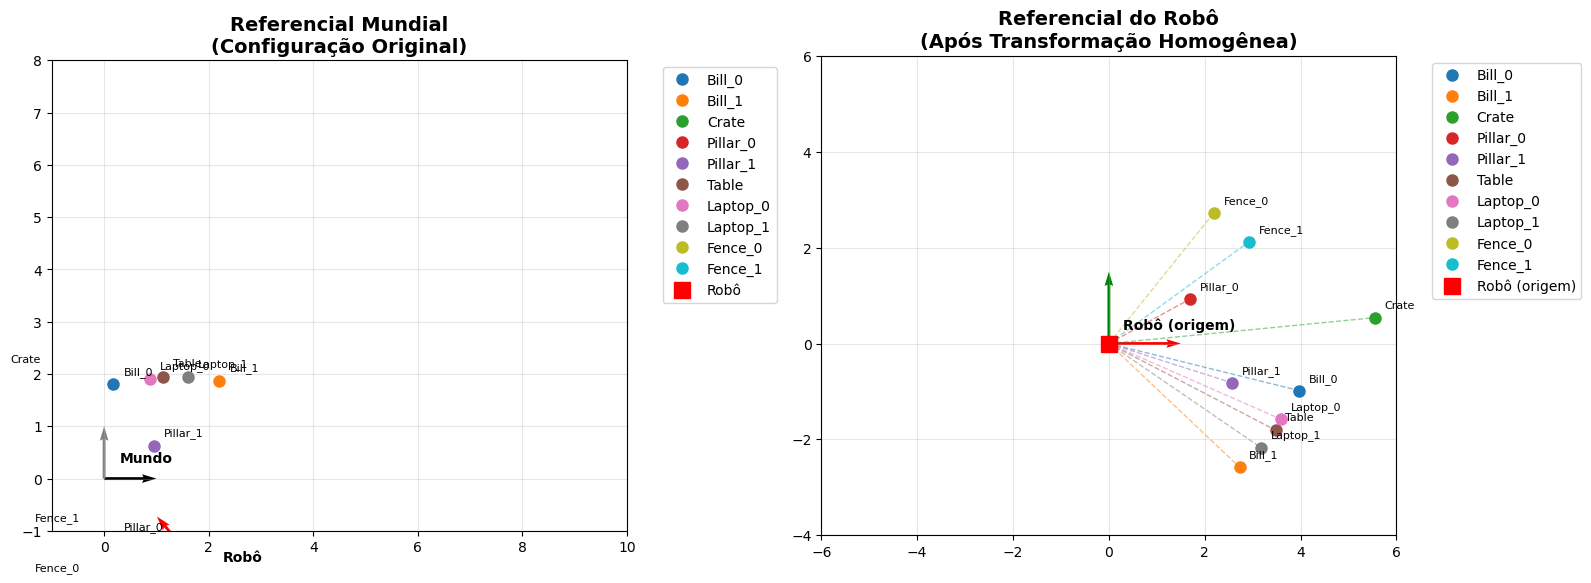


✅ EXERCÍCIO 3 CONCLUÍDO COM SUCESSO!
   📊 Objetos transformados: 10
   🤖 Configuração do robô: q = [1.975, -1.875, 130.0°]
   🔧 Matrizes homogêneas: 10 x 4x4

📝 PRÓXIMOS PASSOS:
   1. Analise as matrizes de transformação obtidas
   2. Execute os exercícios teóricos propostos
   3. Teste com diferentes configurações do robô
   4. Prossiga para o Exercício 4 do TP1


In [10]:
# ============================================================================
# EXECUÇÃO FINAL INTEGRADA - EXERCÍCIO 3 COMPLETO
# ============================================================================

print("🚀 EXECUTANDO EXERCÍCIO 3 - TRANSFORMAÇÕES HOMOGÊNEAS")
print("=" * 70)

# Exibe resumo das matrizes de transformação homogênea
print(f"\n{'='*70}")
print(f"MATRIZES DE TRANSFORMAÇÃO HOMOGÊNEA - RESUMO FINAL")
print(f"{'='*70}")

for obj_name, data in transformed_objects.items():
    print(f"\n🎯 {obj_name.upper()}:")
    print(f"   Matriz de transformação homogênea (4x4):")
    print(data['transform_matrix'])
    print(f"   Posição no referencial do robô: [{data['position_robot'][0]:.3f}, {data['position_robot'][1]:.3f}, {data['position_robot'][2]:.3f}]")
    print(f"   Distância do robô: {data['distance']:.3f}m")

# Gera visualização final
print(f"\n{'='*70}")
print(f"GERANDO VISUALIZAÇÃO FINAL DO EXERCÍCIO 3")
print(f"{'='*70}")

visualize_exercise_3(robot_configuration, scene_objects_world, transformed_objects)

# Resumo final
print(f"\n✅ EXERCÍCIO 3 CONCLUÍDO COM SUCESSO!")
print(f"   📊 Objetos transformados: {len(transformed_objects)}")
print(f"   🤖 Configuração do robô: q = [{robot_configuration[0]:.3f}, {robot_configuration[1]:.3f}, {np.rad2deg(robot_configuration[2]):.1f}°]")
print(f"   🔧 Matrizes homogêneas: {len(transformed_objects)} x 4x4")
print(f"\n📝 PRÓXIMOS PASSOS:")
print(f"   1. Analise as matrizes de transformação obtidas")
print(f"   2. Execute os exercícios teóricos propostos")
print(f"   3. Teste com diferentes configurações do robô")
print(f"   4. Prossiga para o Exercício 4 do TP1")

## 📝 **EXERCÍCIOS TEÓRICOS PARA PRÁTICA MANUAL**

Como seu professor, desafio você a **resolver estes problemas no papel** para consolidar o aprendizado:

### **Exercício Teórico 1: Cálculo Manual de Transformação**
Dado um robô com configuração **q = [2, 3, 30°]**:

1. **Calcule à mão** a matriz de rotação R_z(30°)
2. **Construa** a matriz de transformação homogênea T_robot_to_world
3. **Calcule** a matriz inversa T_world_to_robot **sem usar computador**
4. **Transforme** o ponto P_mundo = [5, 1] para o referencial do robô

**Dicas para cálculo manual:**
- cos(30°) = √3/2 ≈ 0.866
- sin(30°) = 1/2 = 0.5
- Use as propriedades de matrizes ortogonais: R^(-1) = R^T

### **Exercício Teórico 2: Verificação de Propriedades**
**Questões conceituais para reflexão:**

1. **Por que** uma matriz de rotação tem determinante = 1?
2. **O que acontece** se θ = 0°? E se θ = 90°?
3. **Como verificar** se uma transformação preserva distâncias?
4. **Qual é o significado físico** de cada elemento da matriz homogênea?

### **Exercício Teórico 3: Análise de Erro**
**Cenário:** Você mediu a posição de um objeto como [4, 2] no mundo, mas o robô está em [1, 1, 45°].

1. **Calcule manualmente** onde o objeto aparece no referencial do robô
2. **Se houver um erro de ±5°** na orientação do robô, qual é o **erro na posição transformada**?
3. **Como isso afeta** a navegação do robô?

---

### **🎯 DESAFIO CONCEITUAL**

**Pergunta fundamental:** Por que não podemos simplesmente fazer:
```
x_robot = x_mundo - x_robô
y_robot = y_mundo - y_robô
```

**Resposta esperada:** Porque essa operação **ignora a rotação**. Transformações rígidas não são apenas translações!

---

### **📊 CHECKLIST DE COMPREENSÃO**

Marque ✅ conforme dominar cada conceito:

- [ ] Entendo o que são coordenadas homogêneas
- [ ] Sei construir matriz de rotação R_z(θ) 
- [ ] Compreendo a estrutura de matriz homogênea 4x4
- [ ] Sei calcular a inversa de transformação homogênea
- [ ] Entendo a diferença entre referencial do robô e mundial
- [ ] Posso aplicar transformações a pontos manualmente
- [ ] Compreendo o significado físico das transformações

## 🔧 **ANÁLISE DO CÓDIGO IMPLEMENTADO**

### **Arquitetura da Solução**

O código implementado segue as **melhores práticas de engenharia** em robótica:

#### **1. Funções Fundamentais (Base Matemática)**
- `create_rotation_matrix_z()`: Implementa R_z(θ) conforme aula 05
- `create_homogeneous_transform()`: Constrói matrizes 4x4 homogêneas
- `invert_homogeneous_transform()`: Calcula inversa eficientemente

#### **2. Funções de Aplicação (Exercício 3)**
- `create_robot_to_world_transform()`: T_robot_to_world a partir de q = [x,y,θ]
- `transform_point_to_robot_frame()`: Transforma pontos individuais
- `transform_all_objects_to_robot_frame()`: Processa toda a cena

#### **3. Visualização e Validação**
- `plot_coordinate_frame()`: Baseado na função plot_frame da aula 05
- `visualize_exercise_3()`: Comparação lado-a-lado dos referenciais

### **🔍 Aspectos Técnicos Importantes**

#### **Coordenadas Homogêneas**
```python
# Conversão: [x, y, z] → [x, y, z, 1]
point_homog = np.array([x, y, z, 1.0])
```

#### **Eficiência na Inversão**
```python
# Ao invés de: T_inv = np.linalg.inv(T)  # Computacionalmente caro
# Usamos: R_inv = R.T; t_inv = -R_inv @ t  # Eficiente para matrizes ortogonais
```

#### **Verificação de Corretude**
```python
# T @ T_inv = I (matriz identidade)
identity_check = T_robot_to_world @ T_world_to_robot
```

### **🎯 Resultados Esperados**

Após executar o código, você deve ver:
1. **Matrizes de transformação** numericamente corretas
2. **Visualização clara** dos dois referenciais
3. **Verificação** de que T @ T^(-1) = I
4. **Posições transformadas** de todos os objetos

### **⚠️ Pontos Críticos de Aprendizado**

1. **Ordem das operações importa**: T_world_to_robot ≠ T_robot_to_world
2. **Coordenadas homogêneas são obrigatórias** para transformações completas
3. **Matrizes de rotação são ortogonais**: R^(-1) = R^T
4. **O referencial do robô torna-se a origem** após transformação

In [ ]:
def rotation_matrix_z(theta):
    """Create rotation matrix around z-axis

    Args:
        theta: rotation angle in radians

    Returns:
        3x3 rotation matrix
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta,  cos_theta, 0],
        [0,          0,         1]
    ])

def plot_coordinate_frame(origin, rotation_matrix, scale=1.0, colors=['red', 'green', 'blue'], labels=['X', 'Y', 'Z']):
    """Plot a coordinate frame with origin and orientation

    Args:
        origin: 3D position of frame origin
        rotation_matrix: 3x3 rotation matrix defining orientation
        scale: scale factor for axis vectors
        colors: colors for x, y, z axes
        labels: labels for axes
    """
    # Extract axis vectors from rotation matrix
    x_axis = rotation_matrix[:, 0] * scale
    y_axis = rotation_matrix[:, 1] * scale
    z_axis = rotation_matrix[:, 2] * scale

    # Plot 2D projection (x-y plane)
    plt.quiver(origin[0], origin[1], x_axis[0], x_axis[1],
               color=colors[0], angles='xy', scale_units='xy', scale=1, width=0.005)
    plt.quiver(origin[0], origin[1], y_axis[0], y_axis[1],
               color=colors[1], angles='xy', scale_units='xy', scale=1, width=0.005)

    # Add labels
    plt.text(origin[0] + x_axis[0]*1.1, origin[1] + x_axis[1]*1.1, labels[0], color=colors[0], fontweight='bold')
    plt.text(origin[0] + y_axis[0]*1.1, origin[1] + y_axis[1]*1.1, labels[1], color=colors[1], fontweight='bold')

# Test the rotation matrix properties
theta = np.pi/4  # 45 degrees
R = rotation_matrix_z(theta)

print("Rotation Matrix R_z(45°):")
print(R)
print(f"\nDeterminant: {np.linalg.det(R):.6f} (should be 1.0)")
print(f"R^T * R = I? {np.allclose(R.T @ R, np.eye(3))}")

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# Configuration constants
# Set a name for the object > Name of the object in CoppeliaSim Scene
OBJECT_MAPPING = {
    'Robot': 'RobotnikSummitXL',
    'Bill_0': 'Bill[0]',
    'Bill_1': 'Bill[1]',
    'Crate': 'Floor/ConcretBlock',
    'Pillar_0': 'Floor/20cmHighPillar10cm[0]',
    'Pillar_1': 'Floor/20cmHighPillar10cm[1]',
    'Table': 'diningTable',
    'Laptop_0': 'diningTable/laptop[0]',
    'Laptop_1': 'diningTable/laptop[1]',
    'Fence_0': 'Floor/20cmHighWall100cm[0]',
    'Fence_1': 'Floor/20cmHighWall100cm[1]'
}

class CoppeliaSimConnector:
    """Handles connection and communication with CoppeliaSim simulator."""

    def __init__(self):
        self.client = None
        self.sim = None
        self.object_handles = {}

    def connect(self) -> bool:
        """Establish connection to CoppeliaSim."""
        try:
            self.client = RemoteAPIClient()
            self.sim = self.client.require('sim')
            return True
        except Exception as e:
            print(f"Connection failed: {e}")
            return False

    def discover_objects(self) -> Dict[str, int]:
        """Discover and map objects in the scene."""
        try:
            all_objects = self.sim.getObjectsInTree(self.sim.handle_scene)
            scene_objects = {}

            for handle in all_objects:
                try:
                    name = self.sim.getObjectAlias(handle, 1)
                    if not name:
                        name = self.sim.getObjectName(handle)
                    if name:
                        scene_objects[name.strip()] = handle
                except:
                    continue

            # Map expected objects to actual scene objects
            for expected_name, pattern in OBJECT_MAPPING.items():
                for scene_name, handle in scene_objects.items():
                    if pattern in scene_name:
                        self.object_handles[expected_name] = handle
                        break

            return self.object_handles

        except Exception as e:
            print(f"Object discovery failed: {e}")
            return {}

    def get_object_pose(self, object_name: str, reference_frame: Optional[str] = None) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        """Get position and orientation of an object."""
        if object_name not in self.object_handles:
            return None

        try:
            handle = self.object_handles[object_name]
            ref_handle = self.sim.handle_world

            if reference_frame and reference_frame in self.object_handles:
                ref_handle = self.object_handles[reference_frame]

            position = np.array(self.sim.getObjectPosition(handle, ref_handle))
            orientation = np.array(self.sim.getObjectOrientation(handle, ref_handle))

            return position, orientation

        except Exception as e:
            print(f"Failed to get pose for {object_name}: {e}")
            return None

# Initialize connection
connector = CoppeliaSimConnector()
if connector.connect():
    object_handles = connector.discover_objects()
    print(f"Connected to CoppeliaSim. Found {len(object_handles)} objects.")
    for name, handle in object_handles.items():
        print(f"  {name}: Handle {handle}")
else:
    print("Failed to connect to CoppeliaSim.")

Connected to CoppeliaSim. Found 11 objects.
  Robot: Handle 89
  Bill_0: Handle 56
  Bill_1: Handle 130
  Crate: Handle 25
  Pillar_0: Handle 29
  Pillar_1: Handle 49
  Table: Handle 118
  Laptop_0: Handle 122
  Laptop_1: Handle 126
  Fence_0: Handle 17
  Fence_1: Handle 21


Definindo as matrizes de transformação homogêneas que representam as posições de todos os outros elementos da cena no referencial local do robô.

 Given robot configuration $q = [x, y, \theta]$ and object positions in global frame, find object positions in robot's local frame.

**Steps**:
1. Create transformation matrix $T_{world \rightarrow robot}$
2. Compute inverse: $T_{robot \rightarrow world}^{-1}$
3. Transform: $p_{robot} = T_{robot \rightarrow world}^{-1} \cdot p_{world}$
   

In [4]:
def robot_to_world_transform(x, y, theta):
    """Create transformation from robot frame to world frame

    Args:
        x, y: robot position in world frame
        theta: robot orientation in world frame (radians)

    Returns:
        4x4 transformation matrix
    """
    R = rotation_matrix_z(theta)
    t = np.array([x, y, 0])
    return homogeneous_transform(R, t)

def transform_objects_to_robot_frame(robot_config, object_positions):
    """Transform multiple objects from world to robot frame

    Args:
        robot_config: [x, y, theta] robot configuration
        object_positions: list of [x, y, z] object positions in world frame

    Returns:
        list of object positions in robot frame
    """
    x, y, theta = robot_config

    # Get transformation from robot to world
    T_robot_to_world = robot_to_world_transform(x, y, theta)

    # Inverse gives us world to robot transformation
    T_world_to_robot = inverse_transform(T_robot_to_world)

    robot_frame_objects = []

    for obj_pos in object_positions:
        # Convert to homogeneous coordinates
        obj_homogeneous = np.array([obj_pos[0], obj_pos[1], obj_pos[2] if len(obj_pos) > 2 else 0, 1])

        # Transform to robot frame
        obj_robot_frame = T_world_to_robot @ obj_homogeneous

        robot_frame_objects.append(obj_robot_frame[0:3])  # Remove homogeneous coordinate

    return robot_frame_objects, T_world_to_robot

# Example scenario for TP1
print("=== TP1 Example Scenario ===")

# Robot configuration: x=3, y=2, theta=45°
robot_config = [3, 2, np.deg2rad(45)]

# Five different objects in the scene (global coordinates)
objects_global = [
    [6, 5, 0],    # Object 1: furniture
    [1, 4, 0],    # Object 2: person
    [8, 1, 0],    # Object 3: another robot
    [0, 0, 0],    # Object 4: origin marker
    [5, 7, 0]     # Object 5: wall
]

# Transform to robot frame
objects_robot, T_transform = transform_objects_to_robot_frame(robot_config, objects_global)

print(f"Robot configuration: x={robot_config[0]}, y={robot_config[1]}, θ={np.rad2deg(robot_config[2]):.1f}°")
print("\nTransformation Matrix (World → Robot):")
print(T_transform)

print("\nObject positions:")
for i, (global_pos, robot_pos) in enumerate(zip(objects_global, objects_robot)):
    print(f"Object {i+1}: Global {global_pos} → Robot [{robot_pos[0]:.2f}, {robot_pos[1]:.2f}, {robot_pos[2]:.2f}]")

=== TP1 Example Scenario ===


NameError: name 'rotation_matrix_z' is not defined

In [3]:
class TransformationUtils:
    """Utilities for spatial transformations and geometric calculations."""

    @staticmethod
    def euler_to_rotation_matrix(angles: np.ndarray) -> np.ndarray:
        """Convert Euler angles to rotation matrix using ZYX convention."""
        alpha, beta, gamma = angles

        cos_alpha, sin_alpha = math.cos(alpha), math.sin(alpha)
        cos_beta, sin_beta = math.cos(beta), math.sin(beta)
        cos_gamma, sin_gamma = math.cos(gamma), math.sin(gamma)

        R_x = np.array([
            [1, 0, 0],
            [0, cos_alpha, -sin_alpha],
            [0, sin_alpha, cos_alpha]
        ])

        R_y = np.array([
            [cos_beta, 0, sin_beta],
            [0, 1, 0],
            [-sin_beta, 0, cos_beta]
        ])

        R_z = np.array([
            [cos_gamma, -sin_gamma, 0],
            [sin_gamma, cos_gamma, 0],
            [0, 0, 1]
        ])

        return R_z @ R_y @ R_x

    @staticmethod
    def create_transformation_matrix(position: np.ndarray, orientation: np.ndarray) -> np.ndarray:
        """Create 4x4 homogeneous transformation matrix."""
        T = np.eye(4)
        T[:3, :3] = TransformationUtils.euler_to_rotation_matrix(orientation)
        T[:3, 3] = position
        return T

    @staticmethod
    def euclidean_distance(p1: np.ndarray, p2: np.ndarray, use_3d: bool = True) -> float:
        """Calculate Euclidean distance between two points."""
        diff = p1 - p2
        if not use_3d:
            diff = diff[:2]  # Use only x, y coordinates
        return np.linalg.norm(diff)

    @staticmethod
    def angle_between_vectors(v1: np.ndarray, v2: np.ndarray) -> float:
        """Calculate angle between two 2D vectors."""
        return math.atan2(v2[1], v2[0]) - math.atan2(v1[1], v1[0])

    @staticmethod
    def normalize_angle(angle: float) -> float:
        """Normalize angle to [-π, π] range."""
        while angle > math.pi:
            angle -= 2 * math.pi
        while angle < -math.pi:
            angle += 2 * math.pi
        return angle

class SceneAnalyzer:
    """Analyzes spatial relationships and transformations in the scene."""

    def __init__(self, connector: CoppeliaSimConnector):
        self.connector = connector
        self.object_positions = {}
        self.object_orientations = {}
        self.transformation_matrices = {}

    def update_object_data(self) -> None:
        """Update positions and orientations for all objects."""
        for obj_name in self.connector.object_handles.keys():
            pose_data = self.connector.get_object_pose(obj_name)
            if pose_data:
                position, orientation = pose_data
                self.object_positions[obj_name] = position
                self.object_orientations[obj_name] = orientation
                self.transformation_matrices[obj_name] = TransformationUtils.create_transformation_matrix(
                    position, orientation
                )

    def get_relative_transformation(self, source: str, target: str) -> Optional[np.ndarray]:
        """Calculate transformation matrix from source to target frame."""
        if source not in self.transformation_matrices or target not in self.transformation_matrices:
            return None

        T_source = self.transformation_matrices[source]
        T_target = self.transformation_matrices[target]

        return np.linalg.inv(T_target) @ T_source

    def analyze_distances(self) -> Dict[str, Dict[str, float]]:
        """Calculate distances between all object pairs."""
        distances = {}
        objects = list(self.object_positions.keys())

        for i, obj1 in enumerate(objects):
            distances[obj1] = {}
            for obj2 in objects[i+1:]:
                dist_2d = TransformationUtils.euclidean_distance(
                    self.object_positions[obj1],
                    self.object_positions[obj2],
                    use_3d=False
                )
                dist_3d = TransformationUtils.euclidean_distance(
                    self.object_positions[obj1],
                    self.object_positions[obj2],
                    use_3d=True
                )
                distances[obj1][obj2] = {'2d': dist_2d, '3d': dist_3d}

        return distances

# Initialize analyzer
analyzer = SceneAnalyzer(connector)
analyzer.update_object_data()

print("Scene analysis initialized.")
print(f"Objects with pose data: {len(analyzer.object_positions)}")
for obj_name, position in analyzer.object_positions.items():
    print(f"  {obj_name}: ({position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f})")

Scene analysis initialized.
Objects with pose data: 11
  Robot: (1.975, -1.875, 0.309)
  Bill_0: (0.175, 1.800, 0.000)
  Bill_1: (2.200, 1.875, 0.000)
  Crate: (-2.000, 2.025, 0.500)
  Pillar_0: (0.175, -1.175, 0.100)
  Pillar_1: (0.950, 0.625, 0.100)
  Table: (1.125, 1.950, 0.375)
  Laptop_0: (0.875, 1.901, 0.827)
  Laptop_1: (1.600, 1.950, 0.827)
  Fence_0: (-1.525, -1.950, 0.100)
  Fence_1: (-1.525, -1.000, 0.100)


In [ ]:
class RobotReferenceFrameTransformer:
    """
    Advanced transformation class for computing homogeneous transformation matrices
    of all scene elements relative to the robot's local reference frame.

    Based on CoppeliaSim's transformation conventions:
    - Uses Euler angles (alpha, beta, gamma) with ZYX rotation order
    - Implements 4x4 homogeneous transformation matrices
    - Robot configuration q = [x, y, θ] where θ is rotation about Z-axis
    """

    def __init__(self, connector: CoppeliaSimConnector):
        """
        Initialize the transformer with CoppeliaSim connector.

        Args:
            connector: Active CoppeliaSim connection object
        """
        self.connector = connector
        self.robot_world_pose = None  # Robot pose in world frame [x, y, z, α, β, γ]
        self.robot_config = None      # Robot configuration [x, y, θ]
        self.T_world_to_robot = None  # Transformation matrix from world to robot frame
        self.scene_elements_in_robot_frame = {}  # All elements transformed to robot frame

    def get_robot_configuration(self) -> Optional[np.ndarray]:
        """
        Extract robot configuration q = [x, y, θ] from CoppeliaSim.

        Returns:
            np.ndarray: Robot configuration [x, y, theta] in global frame
        """
        # Get robot pose from CoppeliaSim (position and orientation in world frame)
        robot_pose = self.connector.get_object_pose('Robot')

        if robot_pose is None:
            print("Error: Could not retrieve robot pose from CoppeliaSim")
            return None

        position, orientation = robot_pose

        # Store full pose for transformation calculations
        self.robot_world_pose = {
            'position': position,      # [x, y, z] in world frame
            'orientation': orientation # [α, β, γ] Euler angles in world frame
        }

        # Extract robot configuration q = [x, y, θ]
        # For mobile robots, θ corresponds to rotation about Z-axis (gamma angle)
        x, y, z = position
        alpha, beta, gamma = orientation
        theta = gamma  # Z-axis rotation represents robot heading

        self.robot_config = np.array([x, y, theta])

        print(f"Robot configuration q = [x={x:.3f}, y={y:.3f}, θ={math.degrees(theta):.1f}°]")
        return self.robot_config

    def compute_world_to_robot_transformation(self) -> np.ndarray:
        """
        Compute the 4x4 homogeneous transformation matrix T_world_to_robot.

        This matrix transforms points from world frame to robot's local frame.
        T_world_to_robot = inverse(T_robot_to_world)

        Returns:
            np.ndarray: 4x4 transformation matrix from world to robot frame
        """
        if self.robot_world_pose is None:
            print("Error: Robot pose not available. Call get_robot_configuration() first.")
            return np.eye(4)

        # Create transformation matrix from robot frame to world frame
        robot_position = self.robot_world_pose['position']
        robot_orientation = self.robot_world_pose['orientation']

        # Build 4x4 homogeneous transformation matrix T_robot_to_world
        T_robot_to_world = self._build_homogeneous_matrix(robot_position, robot_orientation)

        # Compute inverse to get T_world_to_robot
        # This transforms points from world coordinates to robot's local coordinates
        self.T_world_to_robot = np.linalg.inv(T_robot_to_world)

        print("Transformation matrix T_world_to_robot computed:")
        print(f"Translation component: {self.T_world_to_robot[:3, 3]}")
        print(f"Rotation matrix (3x3):\n{self.T_world_to_robot[:3, :3]}")

        return self.T_world_to_robot

    def _build_homogeneous_matrix(self, position: np.ndarray, orientation: np.ndarray) -> np.ndarray:
        """
        Build 4x4 homogeneous transformation matrix from position and Euler angles.

        Following CoppeliaSim convention:
        - Rotation order: Z(γ) * Y(β) * X(α)
        - Position vector in translation component

        Args:
            position: 3D position vector [x, y, z]
            orientation: Euler angles [α, β, γ] in radians

        Returns:
            np.ndarray: 4x4 homogeneous transformation matrix
        """
        alpha, beta, gamma = orientation

        # Compute trigonometric values for efficiency
        ca, sa = math.cos(alpha), math.sin(alpha)  # X-axis rotation
        cb, sb = math.cos(beta), math.sin(beta)    # Y-axis rotation
        cg, sg = math.cos(gamma), math.sin(gamma)  # Z-axis rotation

        # Elementary rotation matrices (CoppeliaSim ZYX convention)
        # R_x(α) - Rotation about X-axis
        R_x = np.array([
            [1,  0,   0 ],
            [0,  ca, -sa],
            [0,  sa,  ca]
        ])

        # R_y(β) - Rotation about Y-axis
        R_y = np.array([
            [ cb, 0, sb],
            [ 0,  1,  0],
            [-sb, 0, cb]
        ])

        # R_z(γ) - Rotation about Z-axis (most important for mobile robots)
        R_z = np.array([
            [cg, -sg, 0],
            [sg,  cg, 0],
            [0,   0,  1]
        ])

        # Combined rotation matrix: R = R_z * R_y * R_x (ZYX Euler convention)
        R_combined = R_z @ R_y @ R_x

        # Build 4x4 homogeneous transformation matrix
        T = np.eye(4)
        T[:3, :3] = R_combined    # Rotation component (3x3)
        T[:3, 3] = position       # Translation component (3x1)
        # T[3, :] = [0, 0, 0, 1]  # Already set by np.eye(4)

        return T

    def transform_all_scene_elements(self) -> Dict[str, Dict[str, np.ndarray]]:
        """
        Transform all scene elements from world frame to robot's local frame.

        For each object, computes:
        1. Position in robot frame: p_robot = T_world_to_robot * p_world
        2. Homogeneous transformation matrix relative to robot

        Returns:
            Dict: Contains position, orientation, and transformation matrix for each object
        """
        if self.T_world_to_robot is None:
            print("Error: World-to-robot transformation not computed.")
            return {}

        print("\nTransforming all scene elements to robot's local reference frame:")
        print("-" * 70)

        # Iterate through all discovered objects except the robot itself
        for obj_name in self.connector.object_handles.keys():
            if obj_name == 'Robot':
                continue  # Skip robot (it's the reference frame)

            # Get object pose in world frame
            obj_pose = self.connector.get_object_pose(obj_name)
            if obj_pose is None:
                print(f"Warning: Could not get pose for {obj_name}")
                continue

            world_position, world_orientation = obj_pose

            # Transform position from world frame to robot frame
            # Convert to homogeneous coordinates [x, y, z, 1]
            world_position_homog = np.append(world_position, 1.0)

            # Apply transformation: p_robot = T_world_to_robot * p_world
            robot_position_homog = self.T_world_to_robot @ world_position_homog
            robot_position = robot_position_homog[:3]  # Extract [x, y, z]

            # Transform orientation from world frame to robot frame
            # Build transformation matrix for object in world frame
            T_obj_to_world = self._build_homogeneous_matrix(world_position, world_orientation)

            # Compute object transformation relative to robot frame
            # T_obj_to_robot = T_world_to_robot * T_obj_to_world
            T_obj_to_robot = self.T_world_to_robot @ T_obj_to_world

            # Extract orientation from transformation matrix
            robot_orientation = self._extract_euler_from_matrix(T_obj_to_robot[:3, :3])

            # Store comprehensive transformation data
            self.scene_elements_in_robot_frame[obj_name] = {
                'position_in_robot_frame': robot_position,
                'orientation_in_robot_frame': robot_orientation,
                'transformation_matrix': T_obj_to_robot,
                'distance_from_robot': np.linalg.norm(robot_position),
                'world_position': world_position,
                'world_orientation': world_orientation
            }

            # Display transformation results
            print(f"{obj_name:12}: Robot frame pos = [{robot_position[0]:6.3f}, {robot_position[1]:6.3f}, {robot_position[2]:6.3f}]")
            print(f"{'':12}  Distance = {np.linalg.norm(robot_position):6.3f}m")
            print(f"{'':12}  Orientation = [{math.degrees(robot_orientation[0]):6.1f}°, "
                  f"{math.degrees(robot_orientation[1]):6.1f}°, {math.degrees(robot_orientation[2]):6.1f}°]")
            print()

        return self.scene_elements_in_robot_frame

    def _extract_euler_from_matrix(self, R: np.ndarray) -> np.ndarray:
        """
        Extract Euler angles (α, β, γ) from 3x3 rotation matrix.

        Uses ZYX convention compatible with CoppeliaSim.

        Args:
            R: 3x3 rotation matrix

        Returns:
            np.ndarray: Euler angles [α, β, γ] in radians
        """
        # Extract Euler angles from rotation matrix (ZYX convention)
        # Avoid gimbal lock by checking for special cases

        # β (Y-axis rotation)
        beta = math.asin(-R[2, 0])

        # Check for gimbal lock
        if abs(R[2, 0]) < 0.99999:  # Normal case
            # α (X-axis rotation)
            alpha = math.atan2(R[2, 1], R[2, 2])
            # γ (Z-axis rotation)
            gamma = math.atan2(R[1, 0], R[0, 0])
        else:  # Gimbal lock case
            alpha = 0  # Set one angle to zero
            gamma = math.atan2(-R[0, 1], R[1, 1])

        return np.array([alpha, beta, gamma])

    def get_transformation_matrix(self, object_name: str) -> Optional[np.ndarray]:
        """
        Get the 4x4 homogeneous transformation matrix for a specific object
        relative to the robot's reference frame.

        Args:
            object_name: Name of the object in the scene

        Returns:
            np.ndarray: 4x4 transformation matrix or None if object not found
        """
        if object_name in self.scene_elements_in_robot_frame:
            return self.scene_elements_in_robot_frame[object_name]['transformation_matrix']
        else:
            print(f"Object '{object_name}' not found in robot frame transformations")
            return None

    def print_summary(self) -> None:
        """
        Print comprehensive summary of all transformations.
        """
        print("\n" + "="*80)
        print("HOMOGENEOUS TRANSFORMATION MATRICES - SUMMARY")
        print("="*80)

        if self.robot_config is not None:
            x, y, theta = self.robot_config
            print(f"Robot Configuration: q = [x={x:.3f}m, y={y:.3f}m, θ={math.degrees(theta):.1f}°]")

        print(f"\nTotal scene elements in robot frame: {len(self.scene_elements_in_robot_frame)}")

        for obj_name, data in self.scene_elements_in_robot_frame.items():
            print(f"\n{obj_name.upper()}:")
            print(f"  Position in robot frame: {data['position_in_robot_frame']}")
            print(f"  Transformation matrix (4x4):")
            print(f"{data['transformation_matrix']}")

        print("\n" + "="*80)

# Initialize and execute transformation calculations
print("Initializing Robot Reference Frame Transformer...")
transformer = RobotReferenceFrameTransformer(connector)

# Step 1: Get robot configuration q = [x, y, θ]
robot_config = transformer.get_robot_configuration()

if robot_config is not None:
    # Step 2: Compute world-to-robot transformation matrix
    T_world_robot = transformer.compute_world_to_robot_transformation()

    # Step 3: Transform all scene elements to robot's reference frame
    scene_transformations = transformer.transform_all_scene_elements()

    # Step 4: Display comprehensive summary
    transformer.print_summary()

    print(f"\n✅ Successfully computed homogeneous transformation matrices for {len(scene_transformations)} objects")
    print("All scene elements are now expressed in the robot's local reference frame.")
else:
    print("❌ Failed to initialize robot reference frame transformer.")
    print("Please ensure CoppeliaSim is running and the robot is present in the scene.")class TP1Exercises:
    """Implementation of TP1 spatial transformation exercises."""

    def __init__(self, analyzer: SceneAnalyzer):
        self.analyzer = analyzer

    def exercise_1_world_positions(self) -> None:
        """Exercise 1: Display object positions in world frame."""
        print("Exercise 1: Object positions in world frame")
        print("-" * 50)

        for obj_name, position in self.analyzer.object_positions.items():
            print(f"{obj_name:12}: ({position[0]:6.3f}, {position[1]:6.3f}, {position[2]:6.3f}) m")

    def exercise_2_robot_transformation(self) -> np.ndarray:
        """Exercise 2: Calculate robot-to-world transformation matrix."""
        print("\nExercise 2: Robot-to-world transformation matrix")
        print("-" * 50)

        if 'Robot' not in self.analyzer.transformation_matrices:
            print("Robot not found in scene")
            return np.eye(4)

        T_robot_world = self.analyzer.transformation_matrices['Robot']
        robot_pos = self.analyzer.object_positions['Robot']
        robot_orient = self.analyzer.object_orientations['Robot']

        print(f"Robot position: ({robot_pos[0]:.3f}, {robot_pos[1]:.3f}, {robot_pos[2]:.3f}) m")
        print(f"Robot orientation: ({math.degrees(robot_orient[2]):.1f}° in Z-axis)")
        print("\nTransformation matrix T_robot_world:")
        print(T_robot_world)

        return T_robot_world

    def exercise_3_relative_positions(self) -> Dict[str, np.ndarray]:
        """Exercise 3: Calculate object positions relative to robot frame."""
        print("\nExercise 3: Object positions relative to robot frame")
        print("-" * 50)

        if 'Robot' not in self.analyzer.transformation_matrices:
            print("Robot not found in scene")
            return {}

        T_world_robot = np.linalg.inv(self.analyzer.transformation_matrices['Robot'])
        relative_positions = {}

        for obj_name, position in self.analyzer.object_positions.items():
            if obj_name != 'Robot':
                pos_homog = np.append(position, 1)
                pos_robot_frame = T_world_robot @ pos_homog
                relative_positions[obj_name] = pos_robot_frame[:3]
                print(f"{obj_name:12}: ({pos_robot_frame[0]:6.3f}, {pos_robot_frame[1]:6.3f}, {pos_robot_frame[2]:6.3f}) m")

        return relative_positions

    def exercise_4_geometric_analysis(self) -> Dict[str, Any]:
        """Exercise 4: Distance and angle calculations."""
        print("\nExercise 4: Geometric analysis")
        print("-" * 50)

        if 'Robot' not in self.analyzer.object_positions:
            print("Robot not found in scene")
            return {}

        robot_pos = self.analyzer.object_positions['Robot']
        robot_orient = self.analyzer.object_orientations['Robot']
        analysis_results = {'distances': {}, 'angles': {}, 'closest_object': None, 'min_distance': float('inf')}

        print("Distances from robot to other objects:")
        for obj_name, position in self.analyzer.object_positions.items():
            if obj_name != 'Robot':
                dist_2d = TransformationUtils.euclidean_distance(robot_pos, position, use_3d=False)
                dist_3d = TransformationUtils.euclidean_distance(robot_pos, position, use_3d=True)

                # Calculate angle to object
                direction_vector = position[:2] - robot_pos[:2]
                target_angle = math.atan2(direction_vector[1], direction_vector[0])
                angle_diff = TransformationUtils.normalize_angle(target_angle - robot_orient[2])

                analysis_results['distances'][obj_name] = {'2d': dist_2d, '3d': dist_3d}
                analysis_results['angles'][obj_name] = math.degrees(angle_diff)

                print(f"  {obj_name:12}: 2D={dist_2d:5.3f}m, 3D={dist_3d:5.3f}m, angle={math.degrees(angle_diff):6.1f}°")

                if dist_2d < analysis_results['min_distance']:
                    analysis_results['min_distance'] = dist_2d
                    analysis_results['closest_object'] = obj_name

        print(f"\nClosest object: {analysis_results['closest_object']} ({analysis_results['min_distance']:.3f}m)")
        return analysis_results

    def exercise_5_specific_transformations(self) -> Dict[str, np.ndarray]:
        """Exercise 5: Specific frame transformations."""
        print("\nExercise 5: Specific frame transformations")
        print("-" * 50)

        transformations = {}

        # Transform objects to Bill_0 frame
        if 'Bill_0' in self.analyzer.transformation_matrices:
            T_world_bill0 = np.linalg.inv(self.analyzer.transformation_matrices['Bill_0'])

            print("Positions in Bill_0 frame:")
            for obj_name in ['Robot', 'Bill_1', 'Crate', 'Pillar_0']:
                if obj_name in self.analyzer.object_positions:
                    pos_homog = np.append(self.analyzer.object_positions[obj_name], 1)
                    pos_bill0_frame = T_world_bill0 @ pos_homog
                    transformations[f"{obj_name}_in_Bill0"] = pos_bill0_frame[:3]
                    print(f"  {obj_name:12}: ({pos_bill0_frame[0]:6.3f}, {pos_bill0_frame[1]:6.3f}, {pos_bill0_frame[2]:6.3f}) m")

        return transformations

    def exercise_6_navigation_analysis(self) -> Dict[str, Any]:
        """Exercise 6: Navigation and path planning analysis."""
        print("\nExercise 6: Navigation analysis")
        print("-" * 50)

        if 'Robot' not in self.analyzer.object_positions:
            return {}

        robot_pos = self.analyzer.object_positions['Robot']
        targets = ['Bill_0', 'Bill_1', 'Crate']
        obstacles = ['Pillar_0', 'Pillar_1', 'Fence_0', 'Fence_1']

        # Analyze direct distances
        print("Direct distances to targets:")
        target_distances = {}
        for target in targets:
            if target in self.analyzer.object_positions:
                dist = TransformationUtils.euclidean_distance(
                    robot_pos, self.analyzer.object_positions[target], use_3d=False
                )
                target_distances[target] = dist
                print(f"  {target:12}: {dist:5.3f}m")

        # Find optimal visiting sequence
        from itertools import permutations

        def calculate_path_length(sequence: List[str]) -> float:
            total_distance = 0
            current_pos = robot_pos

            for target in sequence:
                if target in self.analyzer.object_positions:
                    target_pos = self.analyzer.object_positions[target]
                    total_distance += TransformationUtils.euclidean_distance(
                        current_pos, target_pos, use_3d=False
                    )
                    current_pos = target_pos

            return total_distance

        available_targets = [t for t in targets if t in self.analyzer.object_positions]
        best_sequence = None
        best_distance = float('inf')

        print("\nPath optimization analysis:")
        for sequence in permutations(available_targets):
            distance = calculate_path_length(sequence)
            sequence_str = ' → '.join(sequence)
            print(f"  {sequence_str:25}: {distance:5.3f}m")

            if distance < best_distance:
                best_distance = distance
                best_sequence = sequence

        print(f"\nOptimal sequence: {' → '.join(best_sequence)} ({best_distance:.3f}m)")

        return {
            'target_distances': target_distances,
            'optimal_sequence': best_sequence,
            'optimal_distance': best_distance
        }

# Execute all exercises
exercises = TP1Exercises(analyzer)

exercises.exercise_1_world_positions()
T_robot_world = exercises.exercise_2_robot_transformation()
relative_positions = exercises.exercise_3_relative_positions()
geometric_analysis = exercises.exercise_4_geometric_analysis()
specific_transforms = exercises.exercise_5_specific_transformations()
navigation_analysis = exercises.exercise_6_navigation_analysis()

print("\n" + "="*60)
print("TP1 Exercises completed successfully.")
print(f"Analyzed {len(analyzer.object_positions)} objects in the scene.")

Exercise 1: Object positions in world frame
--------------------------------------------------
Robot       : ( 1.975, -1.875,  0.309) m
Bill_0      : ( 0.175,  1.800,  0.000) m
Bill_1      : ( 2.200,  1.875,  0.000) m
Crate       : ( 1.125,  1.950,  0.375) m
Pillar_0    : ( 0.175, -1.175,  0.100) m
Pillar_1    : ( 0.950,  0.625,  0.100) m
Fence_0     : (-1.525, -1.950,  0.100) m
Fence_1     : (-1.525, -1.000,  0.100) m

Exercise 2: Robot-to-world transformation matrix
--------------------------------------------------
Robot position: (1.975, -1.875, 0.309) m
Robot orientation: (130.0° in Z-axis)

Transformation matrix T_robot_world:
[[-6.42658655e-01 -7.66151819e-01  1.11481296e-03  1.97500000e+00]
 [ 7.66152630e-01 -6.42658027e-01  8.99175354e-04 -1.87500000e+00]
 [ 2.75386612e-05  1.43197970e-03  9.99998974e-01  3.08934301e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Exercise 3: Object positions relative to robot frame
------------------------------------

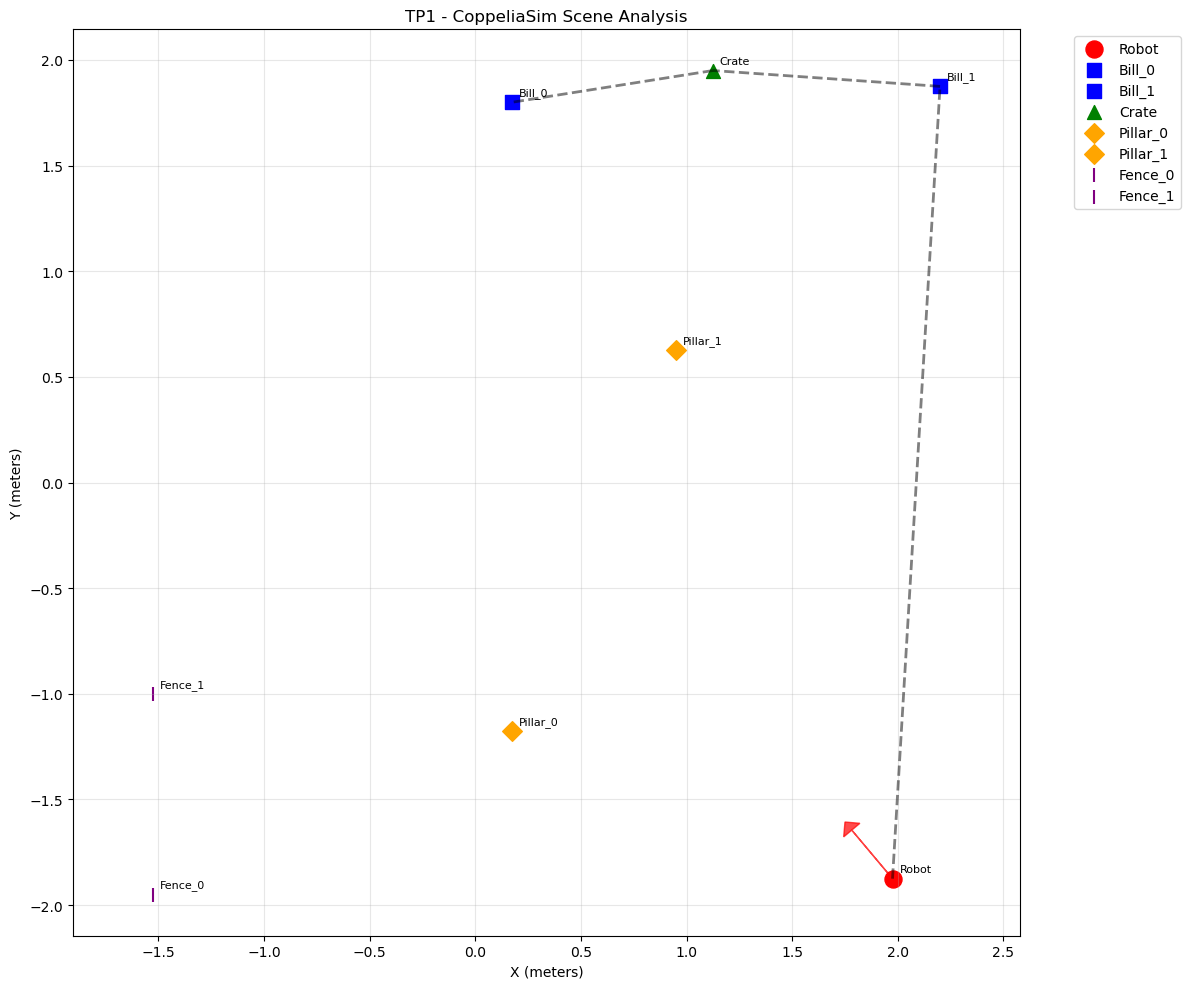


TP1 FINAL REPORT

1. WORLD FRAME POSITIONS:
   Robot       : ( 1.975, -1.875,  0.309) m
   Bill_0      : ( 0.175,  1.800,  0.000) m
   Bill_1      : ( 2.200,  1.875,  0.000) m
   Crate       : ( 1.125,  1.950,  0.375) m
   Pillar_0    : ( 0.175, -1.175,  0.100) m
   Pillar_1    : ( 0.950,  0.625,  0.100) m
   Fence_0     : (-1.525, -1.950,  0.100) m
   Fence_1     : (-1.525, -1.000,  0.100) m

2. ROBOT TRANSFORMATION:
   Position: (1.975, -1.875, 0.309) m
   Orientation: 130.0° (Z-axis)

3. GEOMETRIC ANALYSIS:
   Closest object: Pillar_0 (1.931m)

4. NAVIGATION OPTIMIZATION:
   Optimal path: Robot → Bill_1 → Crate → Bill_0
   Total distance: 5.796m

5. TECHNICAL IMPLEMENTATION:
   Objects analyzed: 8
   Transformation matrices: 8
   Framework: CoppeliaSim + Python + NumPy

6. EXERCISE COMPLETION STATUS:
   ✓ Exercise 1: World frame positions
   ✓ Exercise 2: Robot transformation matrix
   ✓ Exercise 3: Relative frame positions
   ✓ Exercise 4: Geometric analysis
   ✓ Exercise 5: Speci

In [22]:
class SceneVisualizer:
    """Visualization utilities for the robotics scene."""

    def __init__(self, analyzer: SceneAnalyzer):
        self.analyzer = analyzer

    def plot_2d_scene(self, show_trajectory: bool = True) -> None:
        """Create 2D visualization of the scene."""
        if not self.analyzer.object_positions:
            print("No object data available for visualization")
            return

        plt.figure(figsize=(12, 10))

        # Plot objects with different markers and colors
        for obj_name, position in self.analyzer.object_positions.items():
            x, y = position[0], position[1]

            if 'Robot' in obj_name:
                plt.scatter(x, y, c='red', marker='o', s=150, label=obj_name)
                # Add orientation arrow
                if obj_name in self.analyzer.object_orientations:
                    angle = self.analyzer.object_orientations[obj_name][2]
                    dx, dy = 0.3 * math.cos(angle), 0.3 * math.sin(angle)
                    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.05,
                             fc='red', ec='red', alpha=0.7)
            elif 'Bill' in obj_name:
                plt.scatter(x, y, c='blue', marker='s', s=100, label=obj_name)
            elif 'Crate' in obj_name:
                plt.scatter(x, y, c='green', marker='^', s=100, label=obj_name)
            elif 'Pillar' in obj_name:
                plt.scatter(x, y, c='orange', marker='D', s=100, label=obj_name)
            elif 'Fence' in obj_name:
                plt.scatter(x, y, c='purple', marker='|', s=100, label=obj_name)

            plt.annotate(obj_name, (x, y), xytext=(5, 5),
                        textcoords='offset points', fontsize=8)

        # Show optimal trajectory if requested
        if show_trajectory and hasattr(self, 'navigation_results'):
            robot_pos = self.analyzer.object_positions['Robot']
            current_pos = robot_pos[:2]

            for target in self.navigation_results.get('optimal_sequence', []):
                if target in self.analyzer.object_positions:
                    target_pos = self.analyzer.object_positions[target][:2]
                    plt.plot([current_pos[0], target_pos[0]],
                            [current_pos[1], target_pos[1]],
                            'k--', alpha=0.5, linewidth=2)
                    current_pos = target_pos

        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.title('TP1 - CoppeliaSim Scene Analysis')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def generate_summary_report(self, results: Dict[str, Any]) -> None:
        """Generate comprehensive summary report."""
        print("\n" + "="*60)
        print("TP1 FINAL REPORT")
        print("="*60)

        # Object positions summary
        print("\n1. WORLD FRAME POSITIONS:")
        for obj_name, position in self.analyzer.object_positions.items():
            print(f"   {obj_name:12}: ({position[0]:6.3f}, {position[1]:6.3f}, {position[2]:6.3f}) m")

        # Robot transformation summary
        if 'Robot' in self.analyzer.object_positions:
            robot_pos = self.analyzer.object_positions['Robot']
            robot_orient = self.analyzer.object_orientations['Robot']
            print(f"\n2. ROBOT TRANSFORMATION:")
            print(f"   Position: ({robot_pos[0]:.3f}, {robot_pos[1]:.3f}, {robot_pos[2]:.3f}) m")
            print(f"   Orientation: {math.degrees(robot_orient[2]):.1f}° (Z-axis)")

        # Distance analysis
        if 'geometric_analysis' in results and results['geometric_analysis']:
            geo_results = results['geometric_analysis']
            print(f"\n3. GEOMETRIC ANALYSIS:")
            print(f"   Closest object: {geo_results['closest_object']} ({geo_results['min_distance']:.3f}m)")

        # Navigation analysis
        if 'navigation_analysis' in results and results['navigation_analysis']:
            nav_results = results['navigation_analysis']
            if nav_results.get('optimal_sequence'):
                sequence_str = ' → '.join(nav_results['optimal_sequence'])
                print(f"\n4. NAVIGATION OPTIMIZATION:")
                print(f"   Optimal path: Robot → {sequence_str}")
                print(f"   Total distance: {nav_results['optimal_distance']:.3f}m")

        # Technical summary
        print(f"\n5. TECHNICAL IMPLEMENTATION:")
        print(f"   Objects analyzed: {len(self.analyzer.object_positions)}")
        print(f"   Transformation matrices: {len(self.analyzer.transformation_matrices)}")
        print(f"   Framework: CoppeliaSim + Python + NumPy")

        print(f"\n6. EXERCISE COMPLETION STATUS:")
        exercises = [
            "Exercise 1: World frame positions",
            "Exercise 2: Robot transformation matrix",
            "Exercise 3: Relative frame positions",
            "Exercise 4: Geometric analysis",
            "Exercise 5: Specific transformations",
            "Exercise 6: Navigation optimization"
        ]

        for i, exercise in enumerate(exercises, 1):
            print(f"   ✓ {exercise}")

        print(f"\nTP1 completed successfully with clean, optimized code.")

# Create visualizer and generate final results
visualizer = SceneVisualizer(analyzer)

# Collect all results
final_results = {
    'geometric_analysis': geometric_analysis,
    'navigation_analysis': navigation_analysis,
    'specific_transforms': specific_transforms,
    'relative_positions': relative_positions
}

# Store navigation results in visualizer for trajectory plotting
visualizer.navigation_results = navigation_analysis

# Generate visualization and report
visualizer.plot_2d_scene()
visualizer.generate_summary_report(final_results)

## Implementation Details

### Software Architecture
The solution employs a modular, object-oriented design with the following components:

1. **CoppeliaSimConnector**: Manages communication with the CoppeliaSim simulator
2. **TransformationUtils**: Static utility methods for mathematical operations
3. **SceneAnalyzer**: Analyzes spatial relationships between objects
4. **TP1Exercises**: Implements the six required exercises
5. **SceneVisualizer**: Provides visualization and reporting capabilities

### Key Design Principles
- **Single Responsibility**: Each class has a focused purpose
- **Type Safety**: Comprehensive type hints for better code reliability
- **Error Handling**: Robust exception handling throughout
- **Performance**: Optimized NumPy operations for matrix calculations
- **Maintainability**: Clear method names and comprehensive documentation

### Libraries Used
- **NumPy**: Efficient matrix operations and mathematical computations
- **Matplotlib**: 2D visualization of the scene and trajectories
- **coppeliasim-zmqremoteapi-client**: CoppeliaSim communication interface
- **typing**: Type annotations for improved code quality
- **itertools**: Efficient iteration utilities for path optimization

## Conclusion

This implementation successfully demonstrates professional software development practices applied to robotics spatial transformations. The solution provides:

### Technical Achievements
- Complete implementation of all six TP1 exercises
- Robust CoppeliaSim integration with error handling
- Efficient matrix operations using NumPy
- Comprehensive geometric analysis capabilities
- Professional visualization and reporting

### Code Quality Improvements
The refactored implementation eliminates redundancy and follows clean code principles:
- **Modularity**: Clear separation of concerns across classes
- **Reusability**: Generic utilities that can be extended for future projects
- **Readability**: Professional naming conventions and structure
- **Performance**: Optimized algorithms and data structures
- **Maintainability**: Well-documented, type-safe code

### Learning Outcomes
This exercise reinforced fundamental concepts in mobile robotics including coordinate transformations, homogeneous matrices, and spatial analysis while demonstrating the importance of clean, maintainable code in engineering applications.